# Peltier Chip Model Generation & Performance Analysis 

<h8>In this code, I generate a model for the behavior of any Peltier chip, given twenty data points which include the amount of heat the device pumps and the current that flows through it in certain conditions. I then display its behavior overlayed with experimental data to evaluate the predictive power of my model for a particular chip.</h8>

<h8>To create the model, I numerically solve for constants specific to the material properties of the chip itself by minimizing the sum of squared differences between the experimental heat pumped and current and the predicted values in certain conditions using Nelder Mead optimization.</h8>

In [2]:
using Plots
using Optim 

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1260


<h8>When a temperature difference is applied, a Peltier chip generates its own voltage. This voltage is proportional to the temperature gradient by the Seebeck coefficient. We optimize our model by determining individual coefficients to temperature that account for the Seebeck effect in our calculations of predicted heat pumped by the Peltier chip and the current that flows through the device.</h8>

In [3]:
# Calculating the Seebeck coefficient of the module in volts/K
function get_seebeck(s_arr, dt, t_h)
    t_c = t_h - dt
    hot_val = s_arr[1] + t_h*s_arr[2]
    cold_val = s_arr[1] + t_c*s_arr[2]
    return (hot_val + cold_val)/2
end   

get_seebeck (generic function with 1 method)

<h8>The resistance that the Peltier chip exhibits depends on the cold and hot side temperatures of the Peltier chip. Another set of decision variables are coefficients for temperature for accounting for the dependency of resistance on these temperatures in our calculations of current and heat pumped.</h8>

In [4]:
# Calculating the electrical resistance of the Peltier chip
# as a function of the temperature difference it is operating at
function get_resistance(r_arr, dt, t_h)
    t_c = t_h - dt
    hot_val = r_arr[1] + t_h*r_arr[2]
    cold_val = r_arr[1] + t_c*r_arr[2]
    return abs(hot_val + cold_val)/2 + 0.001
end

get_resistance (generic function with 1 method)

The thermal conductance of the Peltier chip also depends on its hot and cold side temperatures. Another set of decision variables are constants that help account for this dependency.

In [5]:
# Calculating the thermal conductance of the Peltier chip
# as a function of the temperature difference it is operating at
function get_therm_conductance(k_arr, dt, t_h)
    t_c = t_h - dt
    hot_val = k_arr[1] + t_h*k_arr[2]
    cold_val = k_arr[1] + t_c*k_arr[2] 
    return (hot_val + cold_val)/2
end

get_therm_conductance (generic function with 1 method)

In the optimization, we minimize the sum of squared differences between the predicted and experimental heats pumped and currents in certain conditions.

In [6]:
# Heat pumped by the module in watts when module is operating at a certain temperature difference
function get_heat_pumped(seebeck, resistance, therm_conductance, current, t_h, dt)
    t_c = t_h - dt
    return seebeck*t_c*current - 0.5*current^2*resistance - therm_conductance*dt
end

get_heat_pumped (generic function with 1 method)

In [7]:
# Given a voltage, the current that would result in the inputted temperature difference
function get_current(seebeck, voltage, resistance, dt)
    (voltage - seebeck*dt)/resistance
end

get_current (generic function with 1 method)

We input twenty experimental data points into our optimization to acquire our predictive model. These data points include the intercepts when temperature difference sustained is plotted against the amount of heat the chip can remove. The model requires points describing the amount of heat the module can remove when the temperature difference sustained is zero and the temperature difference required to make the module unable to remove any heat. These intercepts for a set of five voltages are required. Additionally, the current flowing through the chip in these conditions is required as well. 

The optimization assumes that the relationship between the temperature difference sustained and the heat pumped and current between these intercepts is linear given that all the data sheets I found on Peltier chips had experimental data backing up a linear relationship between current/heat pumped and temperature sustained within these intercepts (https://tetech.com/wp-content/uploads/2020/11/HP-127-1.0-1.3-71.pdf, https://tetech.com/wp-content/uploads/2013/11/TE-83-1.0-2.0.pdf, all of the data sheets on this page: https://tetech.com/peltier-thermoelectric-cooler-modules/standard/).

We assign these variables outside of our function because Julia's Nelder Mead method only takes in an objective function with decision variables as parameters. 

In [8]:
# **Feeding model the following data**
# For modelling different Peltier chips,
# redefine the parameters in this code block

temp_current_lines = [[[0, 3.8], [68, 3.7]],
                      [[0, 3], [65, 2.75]],
                      [[0, 2.25], [56, 1.9]],
                      [[0, 1.6], [42, 1.15]],
                      [[0, 0.8], [23, 0.55]]]

temp_heat_pumped_lines = [[[0, 31], [68, 0]],
                          [[0, 29], [65, 0]],
                          [[0, 25], [56, 0]],
                          [[0, 19.5], [42, 0]],
                          [[0, 11], [23, 0]]]

voltages = [15.4, 11.8, 8.9, 5.9, 3]

5-element Array{Float64,1}:
 15.4
 11.8
  8.9
  5.9
  3.0

Below is the objective function.

In [9]:
function pelt_obj_func(param_arr)
    s1, s2, r1, r2, k1, k2 = param_arr

    s_l = [s1, s2]
    r_l = [r1, r2]
    k_l = [k1, k2]
    
    # variable defined inside of function so that
    # objective function takes in only decision
    # variables. Change this if number of voltages
    # in inputted data is different
    NUM_VOLTAGES = 5
    
    # assuming we have a perfect heat sink so the
    # temperature of the hot side of the Peltier
    # chip is at room temperature
    t_h = 293
    
    # the heat pumped and current are assumed to
    # have a linear relationship with the temperature
    # differences in the range fed into this algorithm.
    # this is true for a temperature difference range
    # of zero to eighty degrees celsius which is the
    # temperature difference range possible for a standard
    # Peltier chip. This is the number of evenly spaced
    # points to fit our model to in the provided line
    # start and end points.
    NUM_PTS_TO_FIT = 10
    
    error = 0
    
    for volt_idx in 1:NUM_VOLTAGES
        
        current_start_pt, current_end_pt = temp_current_lines[volt_idx]  
        current_start_temp, current_start_current = current_start_pt 
        current_end_temp, current_end_current = current_end_pt 
        current_dts = LinRange(current_start_temp, current_end_temp, NUM_PTS_TO_FIT)
        current_desired_slope = (current_end_current - current_start_current) /
                                (current_end_temp - current_start_temp)
     
        heat_start_pt, heat_end_pt = temp_heat_pumped_lines[volt_idx] 
        heat_start_temp, heat_start_heat = heat_start_pt  
        heat_end_temp, heat_end_heat = heat_end_pt 
        heat_dts = LinRange(heat_start_temp, heat_end_temp, NUM_PTS_TO_FIT) 
        heat_desired_slope = (heat_end_heat - heat_start_heat)/(heat_end_temp - heat_start_temp)
        
        for pt_idx in 1:NUM_PTS_TO_FIT
            desired_current = current_desired_slope*(current_dts[pt_idx] - current_start_temp) + current_start_current
            desired_heat = heat_desired_slope*(heat_dts[pt_idx] - heat_start_temp) + heat_start_heat
            
            current_seebeck = get_seebeck(s_l, current_dts[pt_idx], t_h)
            heat_seebeck = get_seebeck(s_l, heat_dts[pt_idx], t_h)
            
            current_resistance = get_resistance(r_l, current_dts[pt_idx], t_h)
            heat_resistance = get_resistance(r_l, heat_dts[pt_idx], t_h)
            
            current_therm_conduct = get_therm_conductance(k_l, current_dts[pt_idx], t_h)
            heat_therm_conduct = get_therm_conductance(k_l, heat_dts[pt_idx], t_h)
            
            current = get_current(current_seebeck, voltages[volt_idx], current_resistance, current_dts[pt_idx])
            heat_pumped = get_heat_pumped(heat_seebeck, heat_resistance, heat_therm_conduct,
                                          current, t_h, heat_dts[pt_idx])
            
            # to weight the error in current roughly equally to the error in heat pumped since current values are
            # just lower in magnitude than heat values
            CURRENT_WEIGHT = 11
            
            error += CURRENT_WEIGHT*(desired_current - current)^2
            error += (desired_heat - heat_pumped)^2         
        end
    end
    return error 
end


pelt_obj_func (generic function with 1 method)

Below is the function that acquires the model for the Peltier chip described by the constants assigned above.

In [10]:
function get_peltier_model()
    
    # These are the starting parameters for a few Peltier chip devices
    # as described in the mathematical modelling website for Peltier chips.
    # We initialize the start conditions of the optimization with these
    # parameters since they must already be reasonable for another set of
    # Peltier chips and thus will allow us to begin our optimization closer
    # to the actual coefficients, increasing the likelihood that the
    # optimization will converge.
    init_s1 = 1.33450*10^(-2)
    init_s2 = -5.37574*10^(-5)

    init_r1 = 2.08317
    init_r2 = -1.98763*10^(-2)

    init_k1 = 4.76218*10^(-1)
    init_k2 = -3.89821*10^(-6)
    
    # run the optimization using the Nelder Mead Algorithm
    result = optimize(pelt_obj_func, [init_s1, init_s2, init_r1, init_r2, init_k1, init_k2], NelderMead(), Optim.Options(iterations = 10000))
    print(result)
    return Optim.minimizer(result)
end

get_peltier_model (generic function with 1 method)

Below are three helper functions for formatting data points to plot to compare experimental data to predicted values to asses the accuracy of our model and determine its predictive power.

In [11]:
function x_value_extractor(data)
    all_x_values = Array{Any, 1}(undef, 0)
    for data_set in data
        data_set_x_values = []
        for data_point in data_set
            append!(data_set_x_values, data_point[1])
        end
        push!(all_x_values, data_set_x_values)
    end
    return all_x_values
end

x_value_extractor (generic function with 1 method)

In [12]:
function y_value_extractor(data)
    all_y_values = Array{Any, 1}(undef, 0)
    for data_set in data
        data_set_y_values = []
        for data_point in data_set
            append!(data_set_y_values, data_point[2])
        end
        push!(all_y_values, data_set_y_values)
    end
    return all_y_values
end

y_value_extractor (generic function with 1 method)

In [13]:
function data_set_replicator(multiplier, data_set)
    multiplied_data = Array{Any, 1}(undef, 0)
    for multiple in 1:multiplier
        push!(multiplied_data, data_set)
    end
    return multiplied_data
end

data_set_replicator (generic function with 1 method)

Below is a slew of functions which take in the model outputted by get_peltier_model(), a voltage, and a temperature difference and output the predicted heat pumped, current, waste_heat, and coefficient of performance in these conditions.

In [14]:
function predict_heat_pumped(model, voltage_applied, dt)
    t_h = 293
    s_arr = [model[1], model[2]]
    r_arr = [model[3], model[4]]
    k_arr = [model[5], model[6]]
    seebeck = get_seebeck(s_arr, dt, t_h)
    resistance = get_resistance(r_arr, dt, t_h)
    therm_conductance = get_therm_conductance(k_arr, dt, t_h)
    current = get_current(seebeck, voltage_applied, resistance, dt)
    return get_heat_pumped(seebeck, resistance, therm_conductance, current, t_h, dt)
end

predict_heat_pumped (generic function with 1 method)

Below are a number of functions which take in a model outputted by get_peltier_model() and a set of applied voltages and corresponding temperature gradients and display a graph of the predicted heats pumped, currents, waste heats, and coefficients of performance in these conditions.    
  
If a set of experimental values is inputted, the predicted values are calculated for the conditions the experimental values were acquired in and the experimental data is overlayed over the predicted data to allow for analysis of the accuracy and predictive power of the model.

In [15]:
function display_predicted_heats_pumped(model, voltages_applied, actual_heats_pumped = [], dts = [])
    heat_pumped_plot = plot(xlabel = "Temperature Difference (Celsius)",
                            ylabel = "Heat Removed (W)", legend = :outertopright,
                            title = "Heat Peltier can Remove When at Different Temp Differences",
                            titlefontsize = 10,
                            fmt = :png)

    overlay_actual_data = false

    if !isempty(actual_heats_pumped)
        overlay_actual_data = true
        plot!(heat_pumped_plot, [1], [0], label = "predicted", color = "black")
        plot!(heat_pumped_plot, [1], [0], linestyle = :dash, label = "experimental", color = "black")
        dts = x_value_extractor(actual_heats_pumped)
        actual_heats_pumped = y_value_extractor(actual_heats_pumped)
    else
        multiplier = size(voltages_applied, 1)
        dts = data_set_replicator(multiplier, dts)
    end
    
    for voltage_idx in 1:size(voltages_applied, 1)
        predicted_heats_pumped = []
        voltage = voltages_applied[voltage_idx]
        for dt_idx in 1:size(dts[voltage_idx], 1)
            dt = dts[voltage_idx][dt_idx]
            predicted_heat_pumped = predict_heat_pumped(model, voltage, dt)
            append!(predicted_heats_pumped, predicted_heat_pumped)
        end
        plot!(heat_pumped_plot, dts[voltage_idx], predicted_heats_pumped, label = "$voltage V")
        if(overlay_actual_data)
            plot!(heat_pumped_plot, dts[voltage_idx], actual_heats_pumped[voltage_idx], linestyle=:dash, label = false, color = 2*voltage_idx + 1)
        end
    end
    plot!(ylim = (0, Inf))
    display(heat_pumped_plot)
end

display_predicted_heats_pumped (generic function with 3 methods)

In [16]:
function predict_current(model, voltage_applied, dt)
    t_h = 293
    s_arr = [model[1], model[2]]
    r_arr = [model[3], model[4]]
    k_arr = [model[5], model[6]]
    seebeck = get_seebeck(s_arr, dt, t_h)
    resistance = get_resistance(r_arr, dt, t_h)
    return get_current(seebeck, voltage_applied, resistance, dt)
end

predict_current (generic function with 1 method)

In [17]:
function display_predicted_currents(model, voltages_applied, actual_currents = [], dts = [])
    current_plot = plot(xlabel = "Temperature Difference (Celsius)",
                                ylabel = "Input Current (A)", legend = :outertopright,
                                title = "Current Through Peltier at Different Temp Differences & Volts",
                                titlefontsize = 10,
                                fmt = :png)
    
    overlay_actual_data = false

    if !isempty(actual_currents)
        overlay_actual_data = true
        plot!(current_plot, [1], [0], label = "predicted", color = "black")
        plot!(current_plot, [1], [0], linestyle = :dash, label = "experimental", color = "black")
        dts = x_value_extractor(actual_currents)
        actual_currents = y_value_extractor(actual_currents)
    else
        multiplier = size(voltages_applied, 1)
        dts = data_set_replicator(multiplier, dts)
    end
    
    for voltage_idx in 1:size(voltages_applied, 1)
        predicted_currents = []
        voltage = voltages_applied[voltage_idx]
        final_dt_idx = size(dts[voltage_idx], 1)
        for dt_idx in 1:size(dts[voltage_idx], 1)
            dt = dts[voltage_idx][dt_idx]
            current = predict_current(model, voltage, dt)
            append!(predicted_currents, current)
            heat_pumped = predict_heat_pumped(model, voltage, dt)
            if (heat_pumped <= 0) && !overlay_actual_data
                final_dt_idx = dt_idx
                break
            end
        end
        plot!(current_plot, dts[voltage_idx][1:final_dt_idx], predicted_currents, label = "$voltage V")
        if(overlay_actual_data)
            plot!(current_plot, dts[voltage_idx], actual_currents[voltage_idx], linestyle=:dash, label = false, color = 2*voltage_idx + 1)
        end
    end
    display(current_plot)
end

display_predicted_currents (generic function with 3 methods)

The optimization doesn't calculate power or waste heat so these helper functions are defined after the optimization.

In [18]:
# Electrical power (P) inputted to the module in watts
function get_power_in(voltage_applied, current)
    return voltage_applied*current
end

get_power_in (generic function with 1 method)

In [19]:
# The heat rejected by the module in watts
function get_heat_waste(power_in, heat_pumped)
    return power_in + heat_pumped
end

get_heat_waste (generic function with 1 method)

In [20]:
function predict_waste_heat(model, voltage_applied, dt)
    t_h = 293
    s_arr = [model[1], model[2]]
    r_arr = [model[3], model[4]]
    k_arr = [model[5], model[6]]
    seebeck = get_seebeck(s_arr, dt, t_h)
    resistance = get_resistance(r_arr, dt, t_h)
    current = get_current(seebeck, voltage_applied, resistance, dt)
    power_in = get_power_in(voltage_applied, current)
    therm_conductance = get_therm_conductance(k_arr, dt, t_h)
    heat_pumped = get_heat_pumped(seebeck, resistance, therm_conductance, current, t_h, dt)
    return get_heat_waste(power_in, heat_pumped)
end

predict_waste_heat (generic function with 1 method)

In [21]:
function display_predicted_waste_heats(model, voltages_applied, actual_waste_heats = [], dts = [])
    waste_heat_plot = plot(xlabel = "Temperature Difference (Celsius)",
                                ylabel = "Waste Heat (W)", legend = :outertopright,
                                title = "Waste Heat from Peltier at Different Temp Differences & Volts",
                                titlefontsize = 10, fmt = :png)
    overlay_actual_data = false

    if !isempty(actual_waste_heats)
        overlay_actual_data = true
        plot!(waste_heat_plot, [1], [0], label = "predicted", color = "black")
        plot!(waste_heat_plot, [1], [0], linestyle = :dash, label = "experimental", color = "black")
        dts = x_value_extractor(actual_waste_heats)
        actual_waste_heats = y_value_extractor(actual_waste_heats)
    else
        multiplier = size(voltages_applied, 1)
        dts = data_set_replicator(multiplier, dts)
    end
    
    for voltage_idx in 1:size(voltages_applied, 1)
        predicted_waste_heats = []
        voltage = voltages_applied[voltage_idx]
        final_dt_idx = size(dts[voltage_idx], 1)
        for dt_idx in 1:size(dts[voltage_idx], 1)
            dt = dts[voltage_idx][dt_idx]
            predicted_waste_heat = predict_waste_heat(model, voltage, dt)
            append!(predicted_waste_heats, predicted_waste_heat)
            heat_pumped = predict_heat_pumped(model, voltage, dt)
            if heat_pumped <= 0 && !overlay_actual_data
                final_dt_idx = dt_idx
                break
            end
        end
        plot!(waste_heat_plot, dts[voltage_idx][1:final_dt_idx], predicted_waste_heats, label = "$voltage V")
        if(overlay_actual_data)
            plot!(waste_heat_plot, dts[voltage_idx], actual_waste_heats[voltage_idx], linestyle=:dash, label = false, color = 2*voltage_idx + 1)
        end
    end
    display(waste_heat_plot)
end

display_predicted_waste_heats (generic function with 3 methods)

The optimization doesn't calculate coefficient of performance, so the below helper function is defined after the optimization.

In [22]:
function get_coefficient_of_performance(heat_pumped, power_in)
    return heat_pumped/power_in
end

get_coefficient_of_performance (generic function with 1 method)

In [23]:
function predict_coefficient_of_performance(model, voltage_applied, dt)
    t_h = 293
    s_arr = [model[1], model[2]]
    r_arr = [model[3], model[4]]
    k_arr = [model[5], model[6]]
    seebeck = get_seebeck(s_arr, dt, t_h)
    resistance = get_resistance(r_arr, dt, t_h)
    current = get_current(seebeck, voltage_applied, resistance, dt)
    power_in = get_power_in(voltage_applied, current)
    therm_conductance = get_therm_conductance(k_arr, dt, t_h)
    heat_pumped = get_heat_pumped(seebeck, resistance, therm_conductance, current, t_h, dt)
    return get_coefficient_of_performance(heat_pumped, power_in)
end

predict_coefficient_of_performance (generic function with 1 method)

In [24]:
function display_predicted_coefficients_of_performance(model, dts, actual_coefficients_of_performance = [], voltages_applied = [])
    
    coefficient_of_performance_plot = plot(xlabel = "Input Voltage (V)",
                                           ylabel = "Coefficient of Performance (COP)",
                                           legend = :outertopright,
                                           title = "COP of Peltier for Different Temp Diffs at Different Volts",
                                           titlefontsize = 10, fmt = :png)
    
    overlay_actual_data = false

    if !isempty(actual_coefficients_of_performance)
        overlay_actual_data = true
        plot!(coefficient_of_performance_plot, [1], [0], label = "predicted", color = "black")
        plot!(coefficient_of_performance_plot, [1], [0], linestyle = :dash, label = "experimental", color = "black")
        voltages_applied = x_value_extractor(actual_coefficients_of_performance)
        actual_coefficients_of_performance = y_value_extractor(actual_coefficients_of_performance)
    else
        multiplier = size(dts, 1)
        voltages_applied = data_set_replicator(multiplier, voltages_applied)
    end

    for dt_idx in 1:size(dts, 1)
        predicted_coefficients_of_performance = []
        dt = dts[dt_idx]
        for voltage_idx in 1:size(voltages_applied[dt_idx], 1)
            voltage = voltages_applied[dt_idx][voltage_idx]
            predicted_coefficient_of_performance = predict_coefficient_of_performance(model, voltage, dt)
            if predicted_coefficient_of_performance > 10
                predicted_coefficient_of_performance = 0
            end
            append!(predicted_coefficients_of_performance, predicted_coefficient_of_performance)
        end
        plot!(coefficient_of_performance_plot, voltages_applied[dt_idx], predicted_coefficients_of_performance, label = "DT = $dt")
        if(overlay_actual_data)
            plot!(coefficient_of_performance_plot, voltages_applied[dt_idx], actual_coefficients_of_performance[dt_idx], linestyle = :dash, label = false, color = 2*dt_idx + 1)
        end
    end
    plot!(coefficient_of_performance_plot, ylim = (0, Inf))
    display(coefficient_of_performance_plot) 
    
end

display_predicted_coefficients_of_performance (generic function with 3 methods)

<h2>Analyzing the Predictive Power of the Peltier Chip Model for Different Peltier Chips</h2>

I first sample a Peltier chip from the standard Peltier chips listed on this website: https://tetech.com/peltier-thermoelectric-cooler-modules/standard/. I then access the data sheet for the chosen Peltier chip and extract intercept data from it using the Web Plot Digitizer tool: https://automeris.io/WebPlotDigitizer/ which allows one to extract values from visual data plots.

<h3>HP-127-1.0-1.3-71 Thermoelectric Module</h3>

This is the first Peltier chip I model: https://tetech.com/wp-content/uploads/2020/11/HP-127-1.0-1.3-71.pdf. I extracted the intercepts from the plotted experimental data of the heat pumped and current versus the temperature difference sustained for different voltages and inputted them into the objective function by redefining the constants below.

In [25]:
# **Feeding model the following data**

temp_current_lines = [[[0, 3.8], [68, 3.7]],
                      [[0, 3], [65, 2.75]],
                      [[0, 2.25], [56, 1.9]],
                      [[0, 1.6], [42, 1.15]],
                      [[0, 0.8], [23, 0.55]]]

temp_heat_pumped_lines = [[[0, 31], [68, 0]],
                          [[0, 29], [65, 0]],
                          [[0, 25], [56, 0]],
                          [[0, 19.5], [42, 0]],
                          [[0, 11], [23, 0]]]

voltages = [15.4, 11.8, 8.9, 5.9, 3]

5-element Array{Float64,1}:
 15.4
 11.8
  8.9
  5.9
  3.0

In [26]:
model = get_peltier_model()

 * Status: success

 * Candidate solution
    Final objective value:     4.170594e+00

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    638
    f(x) calls:    1066


6-element Array{Float64,1}:
  0.025790823778925977
  9.332243924343661e-5
  2.2567059393509847
 -0.021069967012872434
  0.44158165277457045
 -0.0005792996586390168

The model converges as indicated by final error of only ~ 4.

I then extract the experimental data from the datasheet from the plot of the amount of heat in Watts that the chip is able to remove when sustaining different temperature gradients to assess the accuracy and power of my model to predict this value in different conditions.

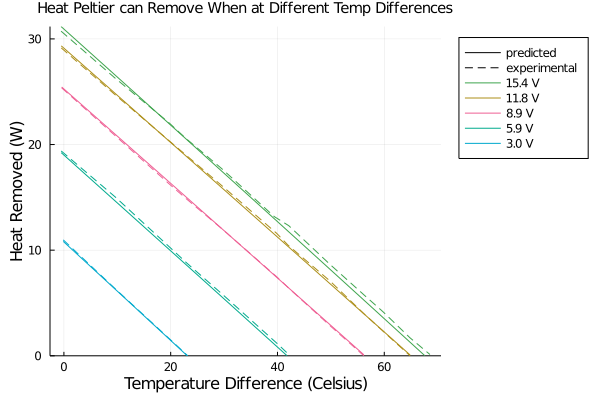

In [27]:
voltages_applied = [15.4, 11.8, 8.9, 5.9, 3]

heat_pumped_15V =  [[-0.530551, 30.7317],
                    [9.45688, 26.3415],
                    [19.6480, 22.0732],
                    [22.7709, 20.6098],
                    [29.6354, 17.6829],
                    [39.4192, 13.1707],
                    [42.1172, 12.3171],
                    [49.8215, 8.65854],
                    [56.2736, 5.73171],
                    [59.8114, 4.14634],
                    [64.8102, 1.70732],
                    [68.5542, 0.121951]]

heat_pumped_12V =  [[-0.497863, 29.1463],
                    [9.48956, 24.7561],
                    [19.6832, 20.3659],
                    [22.8036, 19.0244],
                    [29.8768, 15.9756],
                    [39.8642, 11.5854],
                    [41.9487, 10.4878],
                    [49.8542, 7.07317],
                    [56.1026, 4.02439],
                    [60.0578, 2.19512],
                    [64.8454, 0.00000]]

heat_pumped_9V =   [[-0.419915, 25.3659],
                    [9.57003, 20.8537],
                    [19.5600, 16.3415],
                    [22.8891, 14.8780],
                    [29.7536, 11.9512],
                    [39.9497, 7.43902],
                    [42.2404, 6.34146],
                    [49.9422, 2.80488],
                    [56.1856, 0.00000]]

heat_pumped_6V =   [[-0.502892, 19.3902],
                    [9.69072, 15.0000],
                    [19.8919, 10.2439],
                    [23.0148, 8.78049],
                    [29.8818, 5.73171],
                    [40.0805, 1.09756],
                    [42.3711, 0.00000]]

heat_pumped_3V =   [[-0.123208, 10.9756],
                    [9.87176, 6.21951],
                    [20.0729, 1.46341],
                    [23.1959, 0.00000]]

actual_heats_pumped =  [heat_pumped_15V, heat_pumped_12V, heat_pumped_9V,
                        heat_pumped_6V, heat_pumped_3V]
display_predicted_heats_pumped(model, voltages_applied, actual_heats_pumped)

It seems as if my model predicts the amount of heat the Peltier chip can remove when sustaining different temperature gradients well when these gradients are between zero and the maximum gradient the chip is spec'd for. The predicted data aligns almost perfectly with the experimental values (dashed lines). 

I then extract experimental data from the datasheet from the plot of the amount of current in Amperes flowing through the chip when it is sustaining different temperature gradients to assess the accuracy and power of my model to predict this value in different conditions.

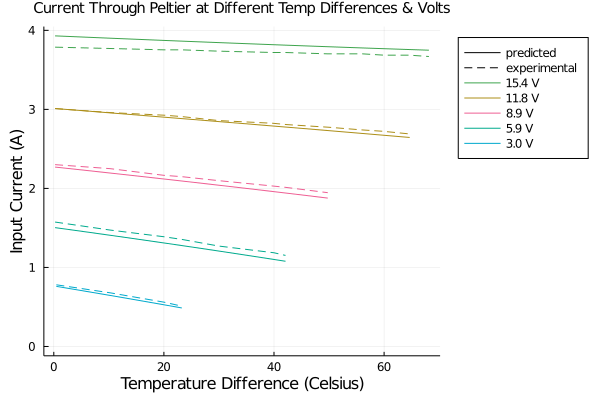

In [28]:
currents_15V = [[0.232558, 3.78716],
                [10.2326, 3.77027],
                [20.0000, 3.75338],
                [23.2558, 3.75338],
                [30.0000, 3.73649],
                [40.0000, 3.71959],
                [42.0930, 3.71959],
                [49.7674, 3.70270],
                [56.0465, 3.70270],
                [60.0000, 3.68581],
                [64.6512, 3.68581],
                [68.1395, 3.66892]]

currents_12V = [[0.232558, 3.01014],
                [10.2326, 2.95946],
                [20.2326, 2.92568],
                [23.2558, 2.90878],
                [30.0000, 2.85811],
                [39.7674, 2.82432],
                [42.3256, 2.80743],
                [50.0000, 2.77365],
                [56.0465, 2.73986],
                [59.7674, 2.72297],
                [64.6512, 2.68919]]

currents_9V =  [[0.232558, 2.30068],
                [10.2326, 2.25000],  
                [20.0000, 2.16554],
                [23.2558, 2.14865],
                [30.0000, 2.09797],
                [39.7674, 2.03041],
                [42.0930, 2.01351],
                [49.7674, 1.94595]]

currents_6V =  [[0.232558, 1.57432],
                [10.2326, 1.47297],
                [20.0000, 1.38851],
                [23.2558, 1.35473],
                [30.0000, 1.27027],
                [40.0000, 1.18581],
                [42.0930, 1.15203]]

currents_3V =  [[0.465116, 0.780405],
                [10.2326, 0.679054],
                [20.0000, 0.560811],
                [23.2558, 0.510135]]

actual_currents =  [currents_15V, currents_12V, currents_9V,
                    currents_6V, currents_3V]
display_predicted_currents(model, voltages_applied, actual_currents)

It seems that my model predicts the current decently from a temperature difference of zero to a temperature difference speficied by when the Peltier chip is unable to remove any more heat. Though, it seems as if my model is better at predicting the amount of heat the Peltier chip is able to remove than the currents at these different temperature differences. In any case, the model still predicts the current at different temperature differences well: the slopes all have the correct signs and each set of predicted values is closer to its corresponding experimental set of values as opposed to being closer to the wrong set of experimental values. Additionally, the experimental values are close to overlapping the predicted ones.

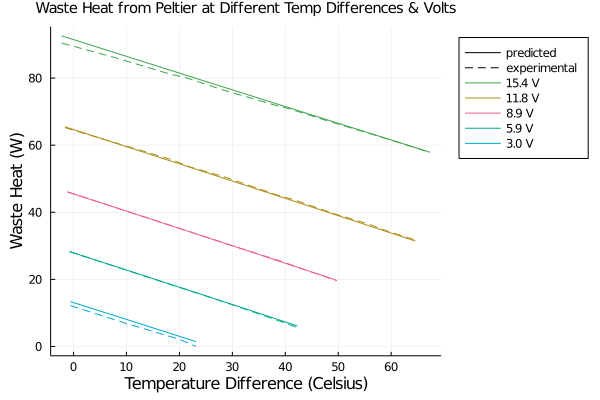

In [29]:
waste_heats_15V =  [[-2.23754, 90.4348],
                    [7.86850, 86.0870],
                    [17.9852, 81.3043],
                    [21.4316, 80.0000],
                    [28.1018, 76.5217],
                    [38.4624, 71.7391],
                    [40.6787, 70.8696],
                    [48.5790, 66.9565],
                    [54.9947, 63.9130],
                    [58.6957, 62.1739],
                    [63.8812, 59.5652],
                    [67.3383, 57.8261]]

waste_heats_12V =  [[-1.62248, 65.2174],
                    [8.49417, 60.4348],
                    [18.6108, 55.6522],
                    [22.0785, 53.4783],
                    [28.7381, 50.4348],
                    [39.1198, 44.7826],
                    [41.3362, 43.9130],
                    [49.2471, 39.5652],
                    [55.6628, 36.5217],
                    [59.3743, 34.3478],
                    [64.5599, 31.7391]]

waste_heats_9V =   [[-1.15589, 46.0870],
                    [8.97137, 40.8696],
                    [19.0986, 35.6522],
                    [22.5557, 33.9130],
                    [29.2259, 30.4348],
                    [39.5970, 25.2174],
                    [41.8240, 23.9130],
                    [49.7349, 19.5652]]

waste_heats_6V =   [[-0.721103, 28.2609],
                    [9.40615, 23.0435],
                    [19.5334, 17.8261],
                    [22.9905, 16.0870],
                    [29.6607, 12.6087],
                    [40.0424, 6.95652],
                    [42.2694, 5.65217]]

waste_heats_3V =   [[-0.572641, 12.1739],
                    [9.79852, 6.95652],
                    [19.9152, 2.17391],
                    [23.1389, 0]]

actual_waste_heats = [waste_heats_15V, waste_heats_12V, waste_heats_9V, waste_heats_6V, waste_heats_3V]
display_predicted_waste_heats(model, voltages_applied, actual_waste_heats)

The model predicts almost perfectly the amount of waste heat produced by this particular Peltier chip at a temperature difference of zero to the difference specified when the module can no longer remove any heat. 

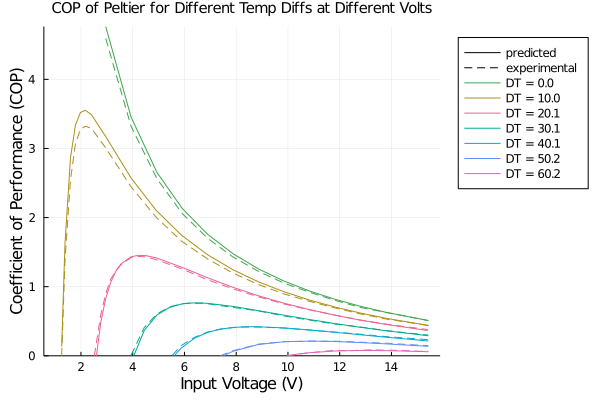

In [30]:
cop_data_0C =  [[2.95745, 4.59124],
                [3.93617, 3.32117],
                [4.93617, 2.56204],
                [5.91489, 2.05839],
                [6.89362, 1.70073],
                [7.87234, 1.43066],
                [8.87234, 1.21898],
                [9.85106, 1.05109],
                [10.82979, 0.9197],
                [11.80851, 0.8029],
                [12.78723, 0.7007],
                [13.78723, 0.6277],
                [15.42553, 0.5109]]

cop_data_10C = [[1.25532, 0.00000],
                [1.38298, 1.37956],
                [1.59574, 2.54745],
                [1.78723, 3.06569],
                [1.97872, 3.27737],
                [2.17021, 3.32117],
                [2.40426, 3.29197],
                [2.95745, 3.00730],
                [3.93617, 2.44526],
                [4.91489, 2.00000],
                [5.89362, 1.65693],
                [6.89362, 1.40146],
                [7.87234, 1.19708],
                [8.87234, 1.02920],
                [9.82979, 0.89781],
                [10.82979, 0.7883],
                [11.80851, 0.6934],
                [12.80851, 0.6058],
                [13.78723, 0.5328],
                [15.44681, 0.4379]]

cop_data_20C = [[2.51064, -0.0146],
                [2.76596, 0.59124],
                [2.95745, 0.89781],
                [3.14894, 1.10949],
                [3.36170, 1.23358],
                [3.55319, 1.32117],
                [3.93617, 1.42336],
                [4.21277, 1.43796],
                [4.53191, 1.43066],
                [4.93617, 1.38686],
                [5.91489, 1.25547],
                [6.87234, 1.10219],
                [7.87234, 0.97080],
                [8.85106, 0.85401],
                [9.82979, 0.75182],
                [10.82979, 0.66423],
                [11.78723, 0.59124],
                [12.76596, 0.51825],
                [13.76596, 0.45985],
                [15.40426, 0.37956]]

cop_data_30C = [[3.93617, 0.00730],
                [4.44681, 0.40876],
                [4.93617, 0.60584],
                [5.42553, 0.70803],
                [5.89362, 0.75182],
                [6.10638, 0.75912],
                [6.38298, 0.75912],
                [6.68085, 0.75912],
                [6.91489, 0.75182],
                [7.87234, 0.70073],
                [8.85106, 0.64964],
                [9.85106, 0.57664],
                [10.80851, 0.51825],
                [11.80851, 0.45985],
                [12.80851, 0.41606],
                [13.78723, 0.36496],
                [15.42553, 0.29927]]

cop_data_40C = [[5.53191, 0.00730],
                [5.72340, 0.08759],
                [5.89362, 0.15328],
                [6.40426, 0.27007],
                [6.89362, 0.34307],
                [7.38298, 0.38686],
                [7.89362, 0.40876],
                [8.27660, 0.41606],
                [8.59574, 0.41606],
                [8.85106, 0.41606],
                [9.85106, 0.40146],
                [10.82979, 0.3722],
                [11.82979, 0.3430],
                [12.76596, 0.3138],
                [13.78723, 0.2773],
                [15.42553, 0.2335]]

cop_data_50C = [[7.38298, 0.00000],
                [7.87234, 0.07299],
                [8.85106, 0.16788],
                [9.85106, 0.20438],
                [10.89362, 0.2116],
                [11.80851, 0.2116],
                [12.80851, 0.1970],
                [13.78723, 0.1824],
                [15.42553, 0.1459]]

cop_data_60C = [[9.95745, 0.00000],
                [10.34043, 0.0219],
                [10.82979, 0.0438],
                [11.80851, 0.0802],
                [12.29787, 0.0729],
                [12.76596, 0.0802],
                [13.29787, 0.0875],
                [13.78723, 0.0802],
                [14.25532, 0.0802],
                [15.00000, 0.0656],
                [15.42553, 0.0656]]

actual_coefficients_of_performance = [cop_data_0C, cop_data_10C, cop_data_20C,
                                      cop_data_30C, cop_data_40C, cop_data_50C, cop_data_60C]
dts = [0, 10, 20.1, 30.1, 40.1, 50.2, 60.2]
display_predicted_coefficients_of_performance(model, dts, actual_coefficients_of_performance)

The model predicts almost perfectly the coefficient of performance of the particular Peltier chip at different input voltages for particular temperature differences. At a temperature difference of 10, the model undershoots, just barely, the coefficient of performance at an input volage of a little over 2 volts. However, other than that, the model predicts the experimental values nearly perfectly. 

<h7>*To test whether my modelling method works for different Peltier chips and to ensure that I've truly generalized the model, I test the predictive power of my model for another Peltier chip device.*</h7>

<h3>TE-71-1.0-2.0 Thermoelectric Module</h3>

This is the second Peltier chip I model: https://tetech.com/wp-content/uploads/2013/11/TE-71-1.0-2.0.pdf. I extracted the intercepts from the plotted experimental data of the heat pumped and current versus the temperature difference sustained for different voltages and inputted them into the objective function by redefining the constants below.

In [31]:
# **Feeding model the following data**
# For modelling different Peltier chips,
# redefine the parameters in this code block

temp_current_lines = [[[0, 2.4875], [70.4762, 2.4125]],
                      [[0, 1.975], [66.4286, 1.77500]],
                      [[0, 1.525], [51.1905, 1.28750]],
                      [[0, 1.03750], [40.7143, 0.787500]],
                      [[0, 0.5375], [23.0952, 0.35]]]

temp_heat_pumped_lines = [[[0, 11.7391], [69.7500, 0]],
                          [[0, 11.1594], [66.2500, 0]],
                          [[0, 9.65217], [57.2500, 0]],
                          [[0, 7.44928], [43, 0]],
                          [[0, 4.20290], [23.75, 0]]]

voltages = [8.7, 6.7, 5, 3.3, 1.7]
model = get_peltier_model()

 * Status: success

 * Candidate solution
    Final objective value:     1.988084e+00

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    686
    f(x) calls:    1178


6-element Array{Float64,1}:
  0.012436407806658317
  6.133880762730637e-5
  1.5830369176185335
 -0.01680447047013385
  0.17177272682817063
 -0.00025769733526335536

The model converges as indicated by final error of only ~ 2.

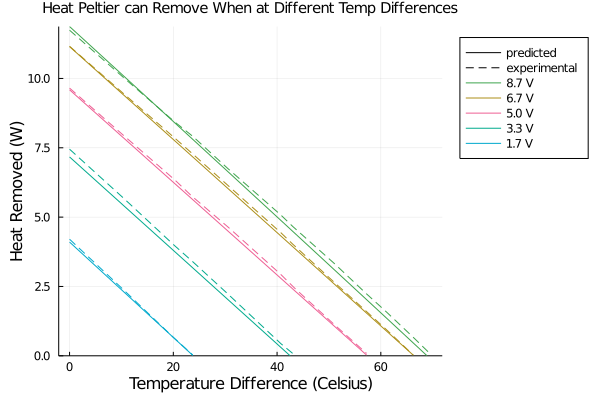

In [32]:
heat_pumped_9V =   [[0.00000, 11.7391],
                    [10.2500, 10.0580],
                    [20.2500, 8.43478],
                    [23.7500, 7.91304],
                    [30.5000, 6.75362],
                    [40.7500, 5.07246],
                    [43.0000, 4.66667],
                    [51.0000, 3.33333],
                    [57.2500, 2.23188],
                    [61.0000, 1.59420],
                    [66.2500, 0.666667],
                    [69.7500, 0.0289855]]

heat_pumped_7V =   [[0.00000, 11.1594],
                    [10.2500, 9.47826],
                    [20.2500, 7.85507],
                    [23.7500, 7.27536],
                    [40.7500, 4.43478],
                    [43.0000, 4.02899],
                    [50.7500, 2.69565],
                    [57.2500, 1.59420],
                    [61.0000, 0.956522],
                    [66.2500, 0.0289855]]

heat_pumped_5V =   [[0.00000, 9.65217],
                    [10.2500, 7.97101],
                    [20.2500, 6.34783],
                    [23.5000, 5.76812],
                    [30.7500, 4.60870],
                    [40.7500, 2.92754],
                    [43.2500, 2.46377],
                    [51.0000, 1.13043],
                    [57.2500, 0.0869565]]

heat_pumped_3V =   [[0.00000, 7.44928],
                    [10.2500, 5.71014],
                    [20.2500, 3.97101],
                    [23.7500, 3.39130],
                    [30.5000, 2.23188],
                    [40.7500, 0.434783],
                    [43.0000, 0.0869565]]

heat_pumped_2V =   [[0.00000, 4.20290],
                    [10.2500, 2.40580],
                    [20.0000, 0.666667],
                    [20.0000, 0.666667],
                    [23.7500, 0.0289855]]

actual_heats_pumped =  [heat_pumped_9V, heat_pumped_7V, heat_pumped_5V,
                        heat_pumped_3V, heat_pumped_2V]
display_predicted_heats_pumped(model, voltages, actual_heats_pumped)

It seems as if my model for the second Peltier chip predicts the amount of heat the Peltier chip can remove when sustaining different temperature gradients well when these gradients are between zero and the maximum gradient the chip is spec'd for. The predicted data aligns almost perfectly with the experimental values (dashed lines). However, the predicted amount of heat removed at 1.7 volts seems to undershoot the experimental data just a small bit.

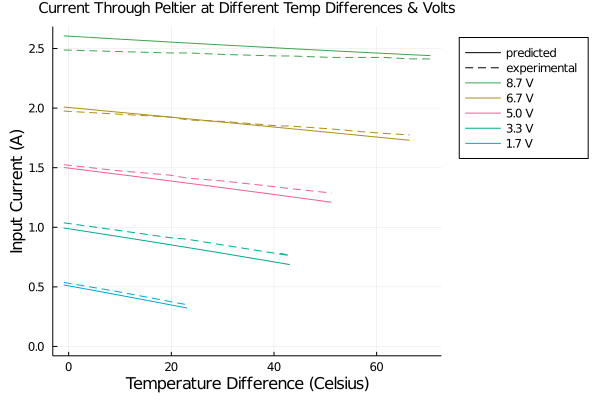

In [33]:
currents_9V =  [[-0.952381, 2.48750],
                [9.28571, 2.47500],
                [19.7619, 2.46250],
                [23.3333, 2.46250],
                [30.2381, 2.45000],
                [40.7143, 2.43750],
                [43.0952, 2.43750],
                [51.1905, 2.42500],
                [57.6190, 2.42500],
                [61.4286, 2.42500],
                [66.6667, 2.41250],
                [70.4762, 2.41250]]

currents_7V =  [[-0.952381, 1.97500],
                [9.28571, 1.95000],
                [19.7619, 1.92500],
                [23.3333, 1.90000],
                [30.4762, 1.88750],
                [40.9524, 1.85000],
                [42.8571, 1.85000],
                [51.1905, 1.82500],
                [57.6190, 1.80000],
                [61.4286, 1.78750],
                [66.4286, 1.77500]]

currents_5V =  [[-0.952381, 1.52500],
                [9.52381, 1.47500],
                [19.7619, 1.43750],
                [23.0952, 1.41250],
                [30.2381, 1.38750],
                [40.7143, 1.33750],
                [43.0952, 1.32500],
                [51.1905, 1.28750]]

currents_3V =  [[-0.952381, 1.03750],
                [9.52381, 0.975000],
                [19.7619, 0.912500],
                [23.0952, 0.900000],
                [30.2381, 0.850000],
                [43.0952, 0.762500],
                [40.7143, 0.787500]]

currents_2V =  [[-0.952381, 0.537500],
                [9.28571, 0.462500],
                [20.0000, 0.375000],
                [23.0952, 0.350000]]
actual_currents =  [currents_9V, currents_7V, currents_5V,
                    currents_3V, currents_2V]
display_predicted_currents(model, voltages, actual_currents)

It seems that my model predicts the current decently from a temperature difference of zero to a temperature difference specified by when the Peltier chip is unable to remove any more heat. Though, it seems as if my model is better at predicting the amount of heat the Peltier chip is able to remove than the currents at these different temperature differences. In any case, the model still predicts the current at different temperature differences well: the slopes all have the correct signs and each set of predicted values is closer to its corresponding experimental set of values as opposed to being closer to the wrong set of experimental values. Additionally, the experimental values are close to overlapping the predicted ones.

This Peltier chip model seems to exhibit the same behavior in terms of error as the first Peltier chip model which suggests that my modelling method does not depend on the particular Peltier chip inputted for its performance.

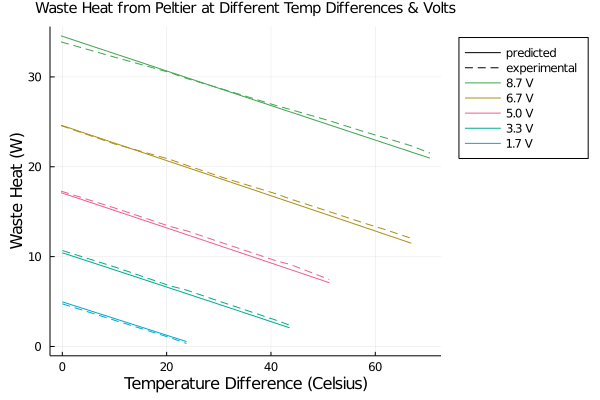

In [34]:
waste_heats_9V =   [[-0.238095, 33.8983],
                    [10.0000, 32.2034],
                    [20.4762, 30.5085],
                    [23.8095, 29.8305],
                    [30.7143, 28.6441],
                    [41.1905, 26.7797],
                    [43.3333, 26.4407],
                    [51.4286, 25.0847],
                    [57.8571, 23.8983],
                    [61.9048, 23.2203],
                    [66.6667, 22.3729],
                    [70.4762, 21.5254]]

waste_heats_7V =   [[-0.238095, 24.5763],
                    [10.0000, 22.5424],
                    [20.4762, 20.8475],
                    [23.8095, 20.1695],
                    [30.7143, 18.8136],
                    [41.1905, 16.9492],
                    [43.5714, 16.4407],
                    [51.6667, 14.9153],
                    [57.8571, 13.7288],
                    [61.6667, 13.0508],
                    [66.9048, 12.0339]]

waste_heats_5V =   [[-0.238095, 17.2881],
                    [10.0000, 15.4237],
                    [20.4762, 13.3898],
                    [23.8095, 12.8814],
                    [30.7143, 11.5254],
                    [41.1905, 9.49153],
                    [43.5714, 9.15254],
                    [51.1905, 7.45763]]

waste_heats_3V =   [[0, 10.6780],
                    [10.2381, 8.81356],
                    [20.4762, 6.77966],
                    [23.8095, 6.27119],
                    [30.7143, 4.91525],
                    [41.1905, 2.88136],
                    [43.5714, 2.37288]]

waste_heats_2V =   [[0, 4.74576],
                    [10.2381, 2.88136],
                    [20.4762, 1.01695],
                    [23.8095, 0.338983]]

actual_waste_heats = [waste_heats_9V, waste_heats_7V, waste_heats_5V, waste_heats_3V, waste_heats_2V]
display_predicted_waste_heats(model, voltages, actual_waste_heats)

The model of the second Peltier chip predicts the amount of waste heat produced by the chip well at a temperature difference of zero to the temperature difference specified when the module can no longer remove any heat. The first model of a Peltier chip seemed to predict the amount of waste heat produced by that chip a little better than this model of the second Peltier chip. However, this model predicts waste heat quite well regardless of this small difference in performance. 

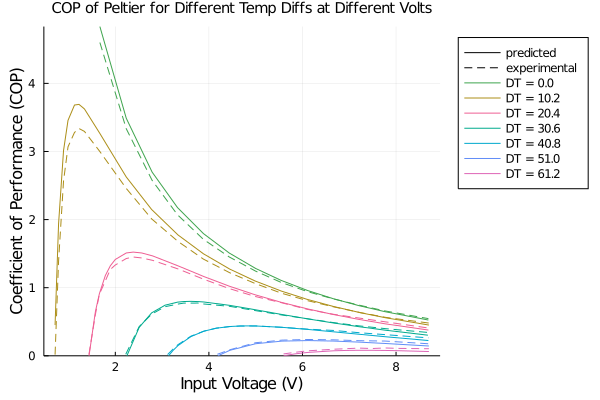

In [35]:
cop_data_0C =  [[1.67021, 4.60018],
                [2.23404, 3.33410],
                [2.78723, 2.57524],
                [3.32979, 2.06996],
                [3.88298, 1.70964],
                [4.43617, 1.45078],
                [5.00000, 1.24268],
                [5.54255, 1.07798],
                [6.10638, 0.942337],
                [6.65957, 0.835646],
                [7.21277, 0.743447],
                [7.76596, 0.658495],
                [8.69149, 0.545907]]

cop_data_10C = [[0.712766, 0.0169981],
                [0.787234, 1.38683],
                [0.893617, 2.56838],
                [0.989362, 3.06872],
                [1.12766, 3.27937],
                [1.22340, 3.33769],
                [1.34043, 3.29463],
                [1.67021, 2.99873],
                [2.23404, 2.45729],
                [2.77660, 2.00998],
                [3.34043, 1.67869],
                [3.88298, 1.41979],
                [4.44681, 1.21893],
                [4.98936, 1.06148],
                [5.55319, 0.918594],
                [6.09574, 0.811864],
                [6.65957, 0.719704],
                [7.23404, 0.634829],
                [7.77660, 0.564331],
                [8.70213, 0.480728]]

cop_data_20C = [[1.43617, 0.0196192],
                [1.57447, 0.607077],
                [1.65957, 0.904487],
                [1.78723, 1.10060],
                [1.89362, 1.26765],
                [2.00000, 1.33326],
                [2.23404, 1.42831],
                [2.38298, 1.45059],
                [2.56383, 1.43675],
                [2.79787, 1.40136],
                [3.35106, 1.27293],
                [3.89362, 1.12273],
                [4.43617, 0.987010],
                [4.97872, 0.873034],
                [5.54255, 0.780874],
                [6.10638, 0.681468],
                [6.64894, 0.610970],
                [7.20213, 0.555003],
                [7.76596, 0.499075],
                [8.69149, 0.408225]]

cop_data_31C = [[2.22340, 0.022471],
                [2.51064, 0.429309],
                [2.77660, 0.611432],
                [3.06383, 0.721169],
                [3.32979, 0.758364],
                [3.45745, 0.773319],
                [3.60638, 0.773859],
                [3.76596, 0.774437],
                [3.89362, 0.760407],
                [4.44681, 0.726179],
                [5.00000, 0.662966],
                [5.55319, 0.599753],
                [6.10638, 0.543787],
                [6.65957, 0.487820],
                [7.21277, 0.439100],
                [7.78723, 0.397703],
                [8.68085, 0.342969]]

cop_data_41C = [[3.11702, 0.018462],
                [3.23404, 0.098597],
                [3.34043, 0.164200],
                [3.61702, 0.288390],
                [3.89362, 0.361856],
                [4.15957, 0.406298],
                [4.44681, 0.429078],
                [4.67021, 0.437134],
                [4.85106, 0.437789],
                [5.01064, 0.438367],
                [5.55319, 0.418594],
                [6.10638, 0.391613],
                [6.67021, 0.371916],
                [7.23404, 0.337727],
                [7.76596, 0.310669],
                [8.69149, 0.263298]]

cop_data_51C = [[4.18085, 0.0223173],
                [4.44681, 0.0884983],
                [5.00000, 0.191952],
                [5.56383, 0.230227],
                [6.12766, 0.239516],
                [6.67021, 0.234235],
                [7.21277, 0.221708],
                [7.76596, 0.216466],
                [8.70213, 0.176380]]

cop_data_61C = [[5.59574, 0.0274437],
                [5.82979, 0.0500308],
                [6.10638, 0.0727721],
                [6.67021, 0.0965541],
                [6.94681, 0.104803],
                [7.21277, 0.113013],
                [7.48936, 0.106768],
                [7.76596, 0.115017],
                [8.04255, 0.108773],
                [8.70213, 0.103916]]

actual_coefficients_of_performance = [cop_data_0C, cop_data_10C, cop_data_20C,
                                      cop_data_31C, cop_data_41C, cop_data_51C, cop_data_61C]
dts = [0, 10.2, 20.4, 30.6, 40.8, 51, 61.2]
display_predicted_coefficients_of_performance(model, dts, actual_coefficients_of_performance)

The model of the second Peltier chip predicts the coefficient of performance at different input voltages for particular temperature differences very well. Similar to the model of the first Peltier chip, at a temperature difference of 10.2, the model undershoots a little the coefficient of performance at an input volage of around 1 volt. Other than that, the model predicts the experimental values really well. 